In [1]:
%matplotlib inline
from pathlib import Path

import joblib
import matplotlib.pyplot as plt
import numpy as np

In [2]:
results_directory = Path('./precomputed_results')

# Experiment with GT MAP

In [3]:
num_iters = 200
batch_size = 1
n_units = 24
methods = ["pomegranate", "pgmax", "pgmpy"]

pgmax_has_lowest_energy = 0
recover_gt = {method: 0 for method in methods}

for rbm_idx in range(50):  # CHECK
    energies_for_rbm = {}
    for method in methods:
        if method == "pgmpy":
            fname = (
                results_directory
                / f"n_units_{n_units}_rbm_idx_{rbm_idx}_{method}.joblib"
            )
            energy = joblib.load(fname)["energy"]
            error = joblib.load(fname)["error"]
        else:
            fname_cpu = (
                results_directory
                / f"n_units_{n_units}_rbm_idx_{rbm_idx}_{method}_cpu_num_iters_{num_iters}_batch_size_1.joblib"
            )
            energy_cpu = joblib.load(fname_cpu)["energy"]
            error_cpu = joblib.load(fname_cpu)["error"]
            fname_gpu = (
                results_directory
                / f"n_units_{n_units}_rbm_idx_{rbm_idx}_{method}_gpu_num_iters_{num_iters}_batch_size_1.joblib"
            )
            energy_gpu = joblib.load(fname_gpu)["energy"]
            error_gpu = joblib.load(fname_gpu)["error"]
            energy = min(energy_cpu, energy_gpu)
            error = min(error_cpu, error_gpu)

        energies_for_rbm[method] = energy

        if error == 0:
            recover_gt[method] += 1

    min_energy = min(energies_for_rbm.values())
    if energies_for_rbm["pgmax"] == min_energy:
        pgmax_has_lowest_energy += 1

print(
    f"PGMax achieves the lowest energy for {pgmax_has_lowest_energy}/50 {n_units}-unit RBMs"
)
for method in methods:
    print(f"{method} recover GT MAP for {recover_gt[method]} /50 {n_units}-unit RBMs")

PGMax achieves the lowest energy for 46/50 24-unit RBMs
pomegranate recover GT MAP for 13 /50 24-unit RBMs
pgmax recover GT MAP for 21 /50 24-unit RBMs
pgmpy recover GT MAP for 1 /50 24-unit RBMs


# Timings vs. RBM sizes

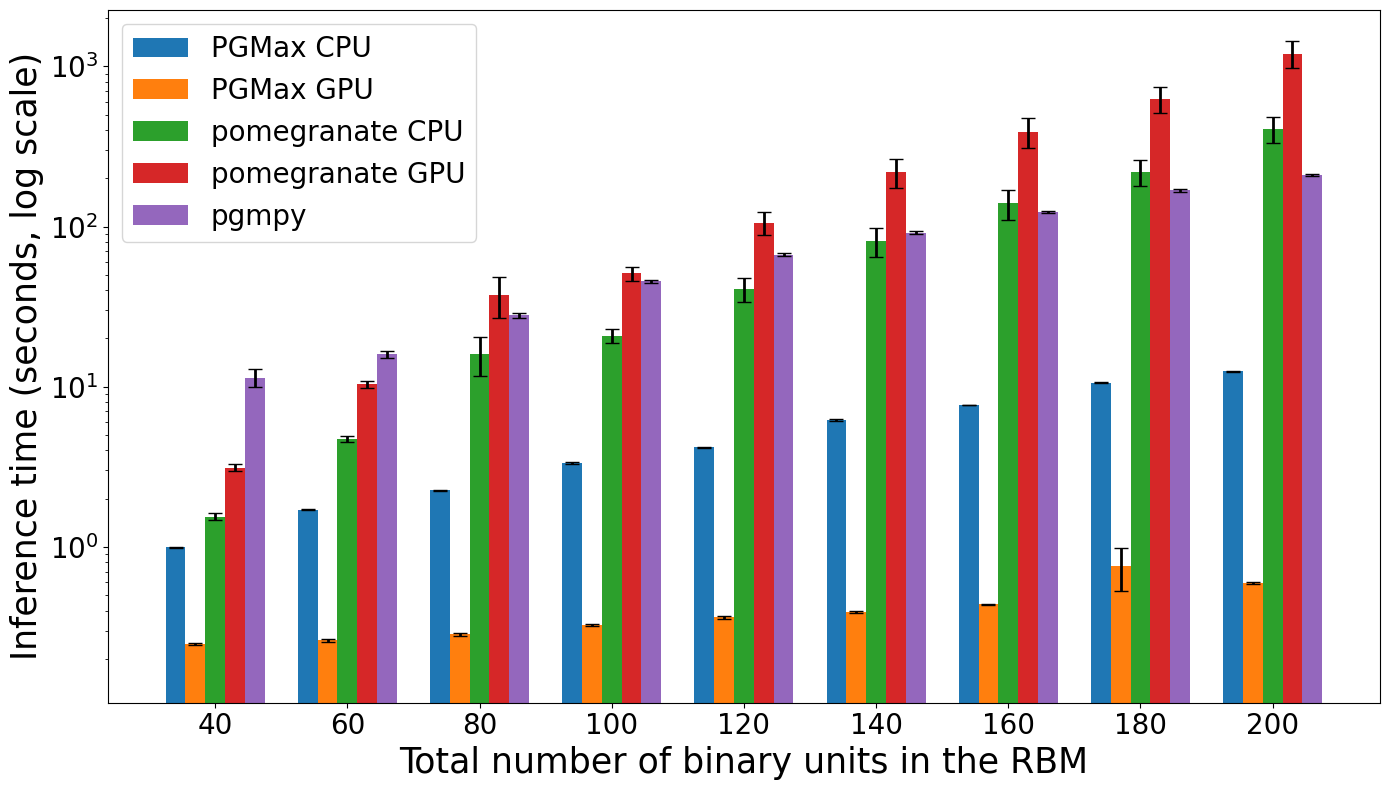

In [4]:
num_iters = 200
batch_size = 100
n_units_list = list(range(40, 210, 20))
methods = ['pgmax_cpu', 'pgmax_gpu', 'pomegranate_cpu', 'pomegranate_gpu', 'pgmpy']

mean_times = {method: [] for method in methods}
ste_times = {method: [] for method in methods}

for n_units in n_units_list:
    inference_times = {method: [] for method in methods}
    for rbm_idx in range(20):
        for method in methods:
            if method == 'pgmpy':
                fname = results_directory / f'n_units_{n_units}_rbm_idx_{rbm_idx}_{method}.joblib'
            else:
                fname = results_directory / f'n_units_{n_units}_rbm_idx_{rbm_idx}_{method}_num_iters_{num_iters}_batch_size_{batch_size}.joblib'

            results = joblib.load(fname)
            inference_times[method].append(results['inference_time'])
    
    for method in methods:
        mean_time = np.mean(inference_times[method])
        ste_time = np.std(inference_times[method]) / np.sqrt(len(inference_times[method]))
        mean_times[method].append(mean_time)
        ste_times[method].append(ste_time)

#################################################

x = np.arange(len(n_units_list))  # the label locations
width = 0.15  # the width of the bars to fit all 5 methods

fig, ax = plt.subplots(figsize=(14, 8))

# Plotting the bars with black error bars
rects1 = ax.bar(x - 2*width, mean_times['pgmax_cpu'], width, yerr=ste_times['pgmax_cpu'], label='PGMax CPU', log=True, capsize=5, error_kw=dict(elinewidth=2, ecolor='black'))
rects2 = ax.bar(x - width, mean_times['pgmax_gpu'], width, yerr=ste_times['pgmax_gpu'], label='PGMax GPU', log=True, capsize=5, error_kw=dict(elinewidth=2, ecolor='black'))
rects3 = ax.bar(x, mean_times['pomegranate_cpu'], width, yerr=ste_times['pomegranate_cpu'], label='pomegranate CPU', log=True, capsize=5, error_kw=dict(elinewidth=2, ecolor='black'))
rects4 = ax.bar(x + width, mean_times['pomegranate_gpu'], width, yerr=ste_times['pomegranate_gpu'], label='pomegranate GPU', log=True, capsize=5, error_kw=dict(elinewidth=2, ecolor='black'))
rects5 = ax.bar(x + 2*width, mean_times['pgmpy'], width, yerr=ste_times['pgmpy'], label='pgmpy', log=True, capsize=5, error_kw=dict(elinewidth=2, ecolor='black'))

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Total number of binary units in the RBM', fontsize=25)
ax.set_ylabel('Inference time (seconds, log scale)', fontsize=25)
# ax.set_title('Inference Times by Method and Number of Units', fontsize=24)
ax.set_xticks(x)
ax.set_xticklabels(n_units_list, fontsize=20)
ax.legend(fontsize=20)
ax.tick_params(axis='y', labelsize=20)

fig.tight_layout()

plt.show()
fig.savefig('results.pdf', dpi=300)

# Inference quality

In [5]:
num_iters = 200
batch_size = 1
methods = ["pomegranate", "pgmax", "pgmpy"]

n_best = []
for n_units in list(range(40, 210, 20)):

    pgmax_has_lowest_energy = 0
    for rbm_idx in range(20):
        energies_for_rbm = {}
        for method in methods:
            if method == "pgmpy":
                fname = (
                    results_directory
                    / f"n_units_{n_units}_rbm_idx_{rbm_idx}_{method}.joblib"
                )
                energy = joblib.load(fname)["energy"]
            else:
                fname_cpu = (
                    results_directory
                    / f"n_units_{n_units}_rbm_idx_{rbm_idx}_{method}_cpu_num_iters_{num_iters}_batch_size_1.joblib"
                )
                energy_cpu = joblib.load(fname_cpu)["energy"]
                fname_gpu = (
                    results_directory
                    / f"n_units_{n_units}_rbm_idx_{rbm_idx}_{method}_gpu_num_iters_{num_iters}_batch_size_1.joblib"
                )
                energy_gpu = joblib.load(fname_gpu)["energy"]
                energy = min(energy_cpu, energy_gpu)

            energies_for_rbm[method] = energy

        min_energy = min(energies_for_rbm.values())
        if energies_for_rbm["pgmax"] == min_energy:
            pgmax_has_lowest_energy += 1

    print(
        f"PGMax achieves the lowest energy for {pgmax_has_lowest_energy}/20 {n_units}-unit RBMs"
    )
    n_best.append(pgmax_has_lowest_energy)

mean = np.mean(n_best)
ste = np.std(n_best) / np.sqrt(len(n_best))
print(f"PGMax on average achieves the lowest energy for {mean:.2f}({ste:.2f})/20 RBMs")

PGMax achieves the lowest energy for 19/20 40-unit RBMs
PGMax achieves the lowest energy for 18/20 60-unit RBMs
PGMax achieves the lowest energy for 17/20 80-unit RBMs
PGMax achieves the lowest energy for 16/20 100-unit RBMs
PGMax achieves the lowest energy for 15/20 120-unit RBMs
PGMax achieves the lowest energy for 16/20 140-unit RBMs
PGMax achieves the lowest energy for 14/20 160-unit RBMs
PGMax achieves the lowest energy for 18/20 180-unit RBMs
PGMax achieves the lowest energy for 20/20 200-unit RBMs
PGMax on average achieves the lowest energy for 17.00(0.61)/20 RBMs


# Appendix: batch size

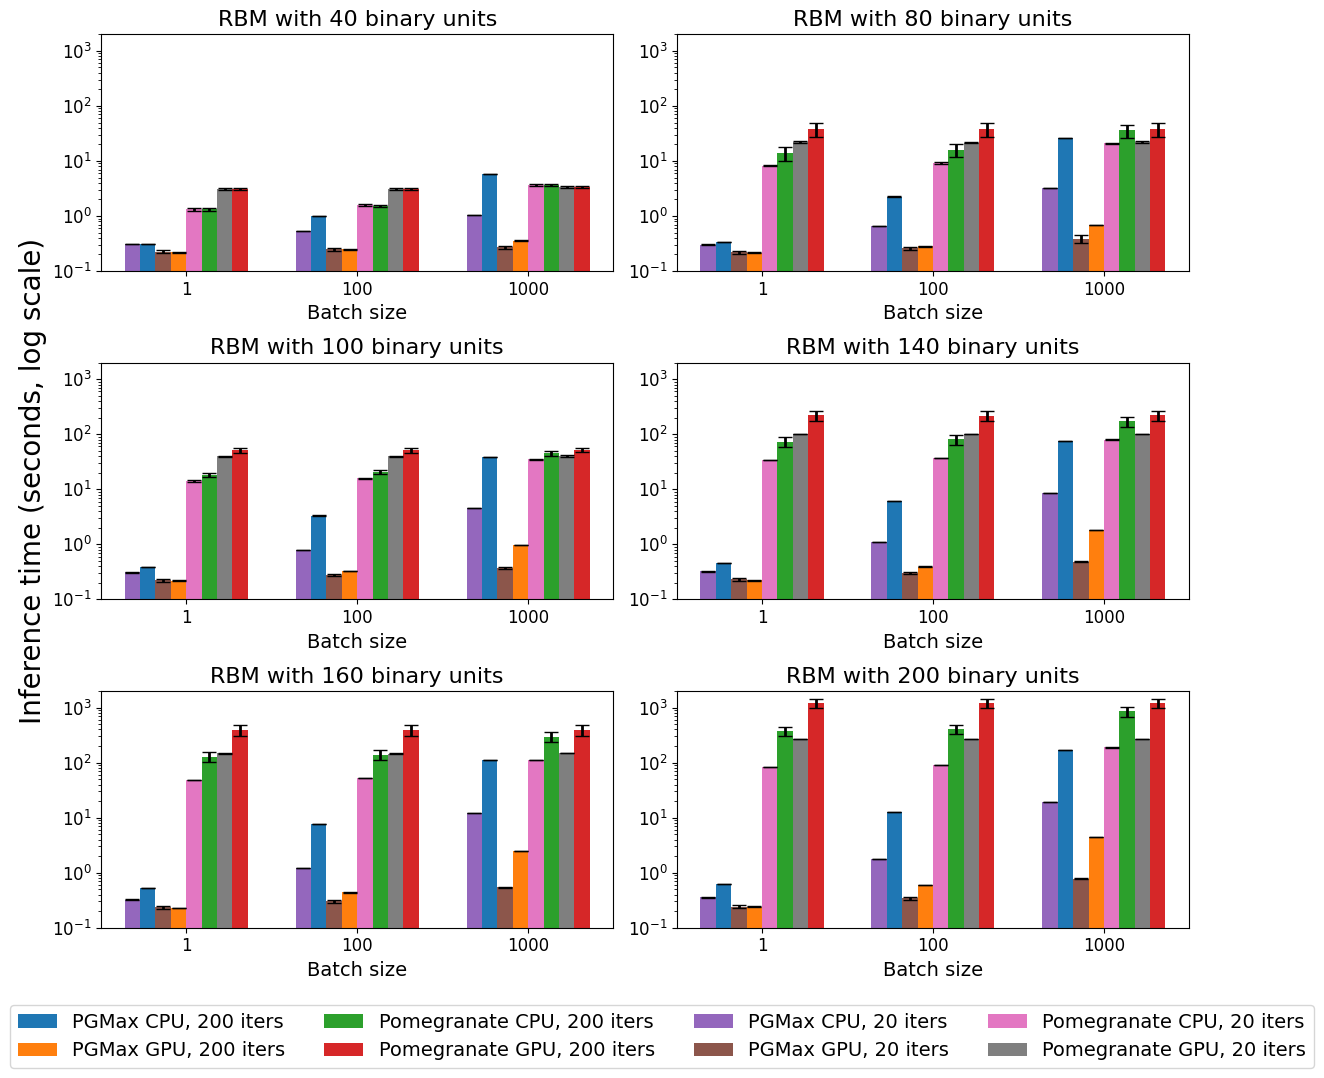

In [6]:
import collections

batch_size_list = [1, 100, 1000]
n_units_list = list(range(40, 210, 20))
methods = [
    ("pgmax_cpu", 20),
    ("pgmax_cpu", 200),
    ("pgmax_gpu", 20),
    ("pgmax_gpu", 200),
    ("pomegranate_cpu", 20),
    ("pomegranate_cpu", 200),
    ("pomegranate_gpu", 20),
    ("pomegranate_gpu", 200),
    "pgmpy",
]

# Store the times
mean_times = {method: collections.defaultdict(list) for method in methods}
ste_times = {method: collections.defaultdict(list) for method in methods}

for batch_size in batch_size_list:
    for n_units in n_units_list:
        for method in methods:
            inference_times = []
            for rbm_idx in range(20):
                if method == "pgmpy":
                    fname = (
                        results_directory
                        / f"n_units_{n_units}_rbm_idx_{rbm_idx}_{method}.joblib"
                    )
                else:
                    name, num_iters = method
                    fname = (
                        results_directory
                        / f"n_units_{n_units}_rbm_idx_{rbm_idx}_{name}_num_iters_{num_iters}_batch_size_{batch_size}.joblib"
                    )

                results = joblib.load(fname)
                inference_times.append(results["inference_time"])

            mean_time = np.mean(inference_times)
            ste_time = np.std(inference_times) / np.sqrt(len(inference_times))
            mean_times[method][n_units].append(mean_time)
            ste_times[method][n_units].append(ste_time)


#################################################

# Plot
x = np.arange(len(batch_size_list))  # the label locations
width = 0.09  # the width of the bars to fit all 5 methods

fig, ax = plt.subplots(3, 2, figsize=(12, 10))

for idx_ax, n_units in [
    ((0, 0), 40),
    ((0, 1), 80),
    ((1, 0), 100),
    ((1, 1), 140),
    ((2, 0), 160),
    ((2, 1), 200),
]:
    # Plotting the bars with black error bars
    rects2 = ax[idx_ax].bar(
        x - 2.5 * width,
        mean_times[("pgmax_cpu", 200)][n_units],
        width,
        yerr=ste_times[("pgmax_cpu", 200)][n_units],
        label="PGMax CPU, 200 iters",
        log=True,
        capsize=5,
        error_kw=dict(elinewidth=2, ecolor="black"),
    )
    rects4 = ax[idx_ax].bar(
        x - 0.5 * width,
        mean_times[("pgmax_gpu", 200)][n_units],
        width,
        yerr=ste_times[("pgmax_gpu", 200)][n_units],
        label="PGMax GPU, 200 iters",
        log=True,
        capsize=5,
        error_kw=dict(elinewidth=2, ecolor="black"),
    )
    rects6 = ax[idx_ax].bar(
        x + 1.5 * width,
        mean_times[("pomegranate_cpu", 200)][n_units],
        width,
        yerr=ste_times[("pomegranate_cpu", 200)][n_units],
        label="Pomegranate CPU, 200 iters",
        log=True,
        capsize=5,
        error_kw=dict(elinewidth=2, ecolor="black"),
    )
    rects8 = ax[idx_ax].bar(
        x + 3.5 * width,
        mean_times[("pomegranate_gpu", 200)][n_units],
        width,
        yerr=ste_times[("pomegranate_gpu", 200)][n_units],
        label="Pomegranate GPU, 200 iters",
        log=True,
        capsize=5,
        error_kw=dict(elinewidth=2, ecolor="black"),
    )
        
    rects1 = ax[idx_ax].bar(
        x - 3.5 * width,
        mean_times[("pgmax_cpu", 20)][n_units],
        width,
        yerr=ste_times[("pgmax_cpu", 20)][n_units],
        label="PGMax CPU, 20 iters",
        log=True,
        capsize=5,
        error_kw=dict(elinewidth=2, ecolor="black"),
    )
    rects3 = ax[idx_ax].bar(
        x - 1.5 * width,
        mean_times[("pgmax_gpu", 20)][n_units],
        width,
        yerr=ste_times[("pgmax_gpu", 20)][n_units],
        label="PGMax GPU, 20 iters",
        log=True,
        capsize=5,
        error_kw=dict(elinewidth=2, ecolor="black"),
    )
    rects5 = ax[idx_ax].bar(
        x + 0.5 * width,
        mean_times[("pomegranate_cpu", 20)][n_units],
        width,
        yerr=ste_times[("pomegranate_cpu", 20)][n_units],
        label="Pomegranate CPU, 20 iters",
        log=True,
        capsize=5,
        error_kw=dict(elinewidth=2, ecolor="black"),
    )
    rects7 = ax[idx_ax].bar(
        x + 2.5 * width,
        mean_times[("pomegranate_gpu", 20)][n_units],
        width,
        yerr=ste_times[("pomegranate_gpu", 20)][n_units],
        label="Pomegranate GPU, 20 iters",
        log=True,
        capsize=5,
        error_kw=dict(elinewidth=2, ecolor="black"),
    )

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax[idx_ax].set_xlabel("Batch size", fontsize=14)
    if n_units == 100:  # third one
        ax[idx_ax].set_ylabel("Inference time (seconds, log scale)", fontsize=20)
    ax[idx_ax].set_title(f"RBM with {n_units} binary units", fontsize=16)
    ax[idx_ax].set_xticks(x)
    ax[idx_ax].set_xticklabels(batch_size_list, fontsize=12)

    ax[idx_ax].tick_params(axis="y", labelsize=12)
    ax[idx_ax].set_ylim(0.1, 2000)
    handles, labels = ax[idx_ax].get_legend_handles_labels()

fig.legend(handles, labels, fontsize=14, bbox_to_anchor=(1.1, 0), ncol=4)
fig.tight_layout()

plt.show()
fig.savefig("batch_size_results.pdf", bbox_inches="tight")

# Appendix: energy

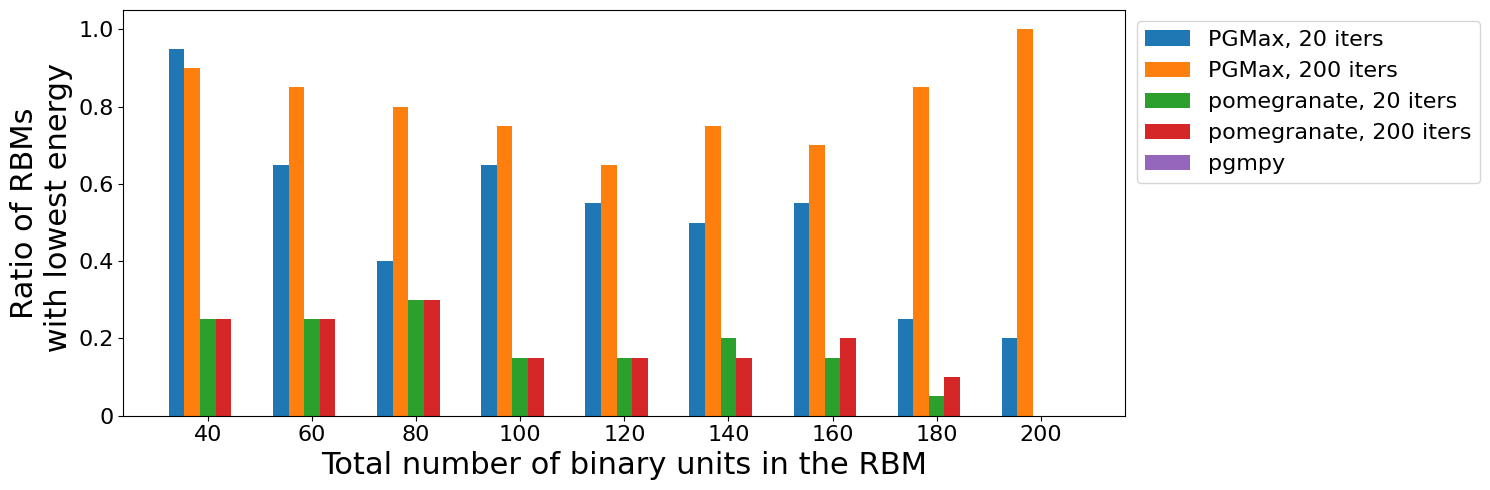

In [7]:
n_units_list = list(range(40, 210, 20))
methods = [
    ("pomegranate", 20),
    ("pomegranate", 200),
    ("pgmax", 20),
    ("pgmax", 200),
    "pgmpy",
]
energies = {method: collections.defaultdict(list) for method in methods}
diff_energies = {method: collections.defaultdict(list) for method in methods}
lowest_energies = {method: np.zeros(len(n_units_list)) for method in methods}

# Store the energies
for idx_unit, n_units in enumerate(n_units_list):
    for rbm_idx in range(20):
        energies_for_rbm = {}
        for method in methods:
            if method == "pgmpy":
                fname = (
                    results_directory
                    / f"n_units_{n_units}_rbm_idx_{rbm_idx}_{method}.joblib"
                )
                energy = joblib.load(fname)["energy"]
            else:
                name, num_iters = method
                fname_cpu = (
                    results_directory
                    / f"n_units_{n_units}_rbm_idx_{rbm_idx}_{name}_cpu_num_iters_{num_iters}_batch_size_1.joblib"
                )
                energy_cpu = joblib.load(fname_cpu)["energy"]
                fname_gpu = (
                    results_directory
                    / f"n_units_{n_units}_rbm_idx_{rbm_idx}_{name}_gpu_num_iters_{num_iters}_batch_size_1.joblib"
                )
                energy_gpu = joblib.load(fname_gpu)["energy"]
                energy = min(energy_cpu, energy_gpu)

            energies_for_rbm[method] = energy

        # Compute energy statistics
        min_energy = min(energies_for_rbm.values())
        for method, energy in energies_for_rbm.items():
            energies[method][n_units].append(energy)
            diff_energies[method][n_units].append(energy - min_energy)
            if energy <= min_energy:
                lowest_energies[method][idx_unit] += 1 / 20


#################################################

# Plot lowest energy

x = np.arange(len(n_units_list))  # the label locations
width = 0.15  # the width of the bars to fit all 5 methods

fig, ax = plt.subplots(figsize=(15, 5))

# Plotting the bars with black error bars
rects1 = ax.bar(
    x - 2 * width,
    lowest_energies[("pgmax", 20)],
    width,
    label="PGMax, 20 iters",
    capsize=5,
    error_kw=dict(elinewidth=2, ecolor="black"),
)
rects2 = ax.bar(
    x - width,
    lowest_energies[("pgmax", 200)],
    width,
    label="PGMax, 200 iters",
    capsize=5,
    error_kw=dict(elinewidth=2, ecolor="black"),
)
rects3 = ax.bar(
    x,
    lowest_energies[("pomegranate", 20)],
    width,
    label="pomegranate, 20 iters",
    capsize=5,
    error_kw=dict(elinewidth=2, ecolor="black"),
)
rects4 = ax.bar(
    x + width,
    lowest_energies[("pomegranate", 200)],
    width,
    label="pomegranate, 200 iters",
    capsize=5,
    error_kw=dict(elinewidth=2, ecolor="black"),
)
rects5 = ax.bar(
    x + 2 * width,
    lowest_energies["pgmpy"],
    width,
    label="pgmpy",
    capsize=5,
    error_kw=dict(elinewidth=2, ecolor="black"),
)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel("Total number of binary units in the RBM", fontsize=22)
ax.set_ylabel("Ratio of RBMs\n with lowest energy", fontsize=22)
# ax.set_title('Inference Times by Method and Number of Units', fontsize=24)
ax.set_xticks(x)
ax.set_xticklabels(n_units_list, fontsize=16)
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=16)
ax.legend(fontsize=16, bbox_to_anchor=(1, 1))

fig.tight_layout()

plt.show()
fig.savefig("lowest_energy_results.pdf", bbox_inches="tight")

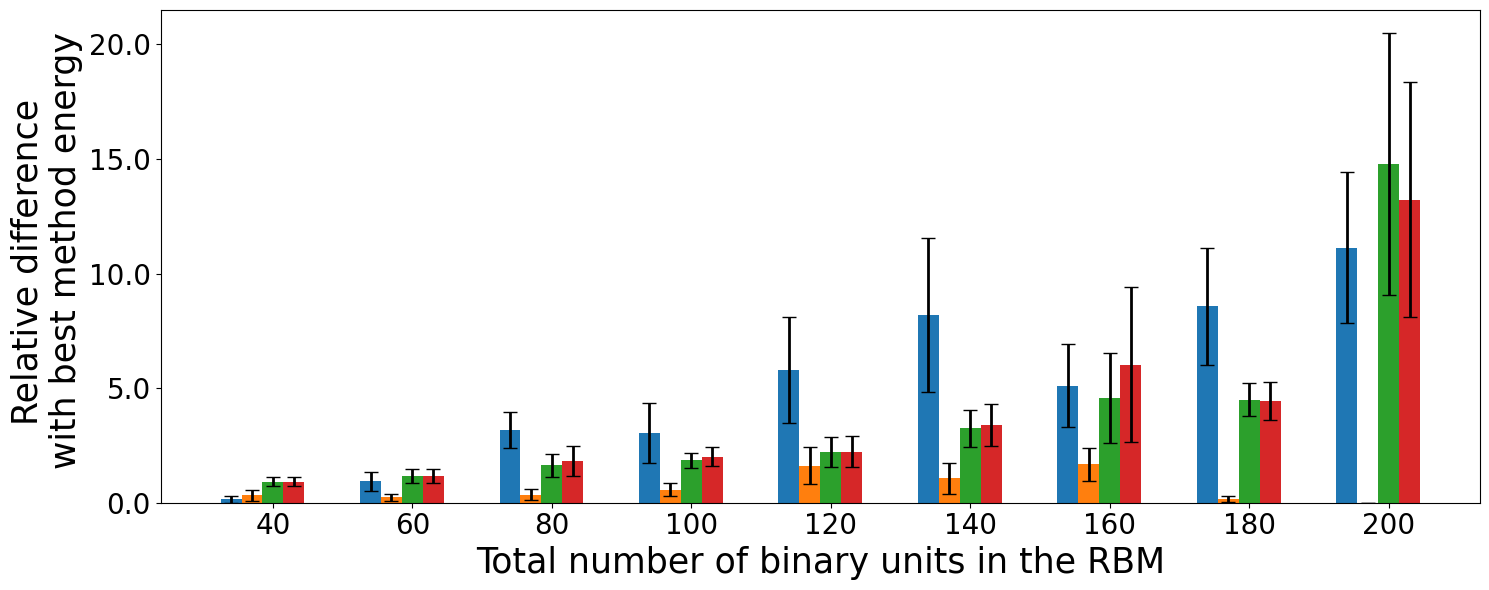

In [8]:
mean_diff_energies = {method: [] for method in methods}
ste_diff_energies = {method: [] for method in methods}
for method in methods:
    for n_units in n_units_list:
        diffs = diff_energies[method][n_units]
        mean_diff = np.mean(diffs)
        ste_diff = np.std(diffs) / np.sqrt(len(diffs))
        mean_diff_energies[method].append(mean_diff)
        ste_diff_energies[method].append(ste_diff)


#################################################

# Plot diff energies

x = np.arange(len(n_units_list))  # the label locations
width = 0.15  # the width of the bars to fit all 5 methods

fig, ax = plt.subplots(figsize=(15, 6))

# Plotting the bars with black error bars
rects1 = ax.bar(
    x - 2 * width,
    mean_diff_energies[("pgmax", 20)],
    width,
    yerr=ste_diff_energies[("pgmax", 20)],
    label="PGMax, 20 iters",
    capsize=5,
    error_kw=dict(elinewidth=2, ecolor="black"),
)
rects2 = ax.bar(
    x - width,
    mean_diff_energies[("pgmax", 200)],
    width,
    yerr=ste_diff_energies[("pgmax", 200)],
    label="PGMax, 200 iters",
    capsize=5,
    error_kw=dict(elinewidth=2, ecolor="black"),
)
rects3 = ax.bar(
    x,
    mean_diff_energies[("pomegranate", 20)],
    width,
    yerr=ste_diff_energies[("pomegranate", 20)],
    label="pomegranate, 20 iters",
    capsize=5,
    error_kw=dict(elinewidth=2, ecolor="black"),
)
rects4 = ax.bar(
    x + width,
    mean_diff_energies[("pomegranate", 200)],
    width,
    yerr=ste_diff_energies[("pomegranate", 200)],
    label="pomegranate, 200 iters",
    capsize=5,
    error_kw=dict(elinewidth=2, ecolor="black"),
)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel("Total number of binary units in the RBM", fontsize=25)
ax.set_ylabel("Relative difference \n with best method energy", fontsize=25)
# ax.set_title('Inference Times by Method and Number of Units', fontsize=24)
ax.set_xticks(x)
ax.set_xticklabels(n_units_list, fontsize=20)
ax.set_yticks([0, 5, 10, 15, 20])
ax.set_yticklabels(["0.0", "5.0", "10.0", "15.0", "20.0"], fontsize=20)

fig.tight_layout()

plt.show()
fig.savefig("diff_energy_results.pdf", dpi=300)